# Модель для рекомендательной системы

### О задании
Предстояло построить рекомендательную систему постов в социальной сети. То есть провести EDA, выбрать и обучить модель, выгрузить преобразованные данне и обернуть модель в сервис, который отправляет id, topic, text постов.

**Ограничения сервиса:** 
1. Скорость работы сервиса. Средняя время работы одного запроса должно быть равно 0,5 секунд
2. Установлены ограничения по памяти: не больше, чем 4 гб RAM на запуск 
3. Установлены ограничения на качество модели: HitRate@5 должен быть больше 0.52

###  Кратко о ноутбуке
Этот ноутбук отвечает за *EDA* и обучение модели для финального проекта курса **"Start ML" (karpov.courses)**
В задании предлагалось построить рекомендательную систему на основе заранее предоставленных данных. Данные должны были браться из БД, преобразовываться, исследоваться и готовиться для обучения и замера качества модели самостоятельно.
В данном проекте использовался "Контентный подход", а именно обучение выбранной модели из классических алгоритмов. 
В итоговом решении использовался **CatBoost** (модель бинарной классификации), так как показал лучшие результаты.
В данных была проблема несбалансированности, поэтому пришлось сокращать тренировочную и тестовую выборку, а также использовать сторонюю библиотеку **imbalanced-learn** для выравнивания классов.Также данные нужно было распределить по времени (временной ряд), так как приходящие посты будут новыми, ранее неизвестными, поэтому обучаем модель с этим условием. В ноутбуке представлена работа с памятью и весом датафрейма из-за ограничения по памяти. Также для работы с текстом был использован TfidfVectorizer

**Пометка о EDA:** в ноутбуке закомменчен вывод корреляции фичей, просмотр распределений возраста, пола и тд, преобразование дат и тп. для уменьшения выводов ноутбука.
### Метрика
Для оценивания обучаемости модели использовалась PR-AUC кривая(из-за несбалансированности), precision, recall, f1, финальная метрика была на стороне проверяющей системы. 
Финальная метрика: Hitrate@5, топ 5 постов по предсказаниям модели. Она принимает значение 1, если среди предложенных 5 рекомендаций хотя бы 1 получила в итоге like от пользователя. Даже если все 5 предложенных постов в итоге будут оценены пользователем, все равно hitrate будет равен 1. Метрика бинарная! В противном случае, если ни один из предложенных постов не был оценен пользователем, hitrate  принимает значение 0. 

### Данные 
Данные представлены 3 таблицами (пользователи, посты и действия пользователя с постами). 
<img src='./user_table.png' width=500, heigth=500>
<img src='./post_table.png' width=500, heigth=500>
<img src='./feed_table.png' width=500, heigth=500>

In [1]:
!pip install sqlalchemy==1.4.35
!pip install pandas==1.4.2
!pip install catboost==1.0.6
!pip install numpy==1.22.4
!pip install scikit_learn==1.1.1
!pip install psycopg2-binary==2.9.3
!pip install category-encoders==2.5.0




In [2]:
import pandas as pd
import numpy as np 
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sqlalchemy import create_engine

def batch_load_sql(query: str) -> pd.DataFrame:
    """Функция для партийной выгрузки данных из БД. 
       Нужна для того, чтобы экономить память при выгрузке."""
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://DB..."
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [6]:
def load_features1() -> pd.DataFrame:
    query = """SELECT * FROM public.user_data"""
    df = batch_load_sql(query)
    return df

In [7]:
df1 = load_features1()

In [8]:
df1

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [9]:
df1.to_csv('DF1.csv')

In [9]:
tuple_user = tuple(df1['user_id'].values)

In [10]:
def load_features2() -> pd.DataFrame:
    query = """SELECT * FROM public.post_text_df LIMIT 200"""
    df = batch_load_sql(query)
    return df

In [11]:
df2 = load_features2()

In [12]:
df2

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
195,170,Tsunami cost hits Jakarta shares\n\nThe stock ...,business
196,171,VW considers opening Indian plant\n\nVolkswage...,business
197,172,"Go-ahead for Balkan oil pipeline\n\nAlbania, B...",business
198,173,House prices rebound says Halifax\n\nUK house ...,business


In [13]:
df2.to_csv('DF2.csv')

In [13]:
tuple_post = tuple(df2['post_id'].values)

**Следующий две строчки кода можно пропустить, тк хотел просто посмотреть на велечину датасета при мерже кроссом пользователей и постов (датасет не подходит по размеру)**

In [14]:
df = df1.merge(df2, how='cross')

In [15]:
df

,user_id,gender,age,country,city,exp_group,os,source,post_id,text,topic
0,200,1,34,Russia,Degtyarsk,3,Android,ads,1,UK economy facing major risks\n\nThe UK manufa...,business
1,200,1,34,Russia,Degtyarsk,3,Android,ads,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,200,1,34,Russia,Degtyarsk,3,Android,ads,3,Asian quake hits European shares\n\nShares in ...,business
3,200,1,34,Russia,Degtyarsk,3,Android,ads,4,India power shares jump on debut\n\nShares in ...,business
4,200,1,34,Russia,Degtyarsk,3,Android,ads,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...,...,...,...,...,...,...,...,...
32640995,168552,1,16,Russia,Ivanteyevka,4,Android,organic,170,Tsunami cost hits Jakarta shares\n\nThe stock ...,business
32640996,168552,1,16,Russia,Ivanteyevka,4,Android,organic,171,VW considers opening Indian plant\n\nVolkswage...,business
32640997,168552,1,16,Russia,Ivanteyevka,4,Android,organic,172,"Go-ahead for Balkan oil pipeline\n\nAlbania, B...",business
32640998,168552,1,16,Russia,Ivanteyevka,4,Android,organic,173,House prices rebound says Halifax\n\nUK house ...,business


**Дальше идет важная часть**

In [17]:
def load_features3() -> pd.DataFrame:
    query = f"""SELECT * FROM public.feed_data WHERE user_id IN {tuple_user} AND post_id IN {tuple_post}"""
    df = batch_load_sql(query)
    return df

In [ ]:
df3 = load_features3()

In [ ]:
memory_usage = df3.memory_usage(deep=True)
np.sum(memory_usage / 1024 ** 2)

In [15]:
df = df3.merge(df1, how='inner', on='user_id')
df = df.merge(df2, how='inner', on='post_id')

In [16]:
df

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-20 09:12:14,98623,21,view,0,1,35,Russia,Buinsk,1,iOS,ads,WorldCom trial starts in New York\n\nThe trial...,business
1,2021-10-19 14:08:03,64306,21,view,0,0,20,Ukraine,Avdiivka,1,iOS,ads,WorldCom trial starts in New York\n\nThe trial...,business
2,2021-10-11 10:26:27,19679,21,view,0,1,35,Russia,Staryy Oskol,1,iOS,ads,WorldCom trial starts in New York\n\nThe trial...,business
3,2021-12-08 06:29:14,98627,21,view,0,1,18,Russia,Kemerovo,2,iOS,ads,WorldCom trial starts in New York\n\nThe trial...,business
4,2021-11-06 14:30:51,77461,21,view,0,0,18,Russia,Zhigulevsk,3,Android,ads,WorldCom trial starts in New York\n\nThe trial...,business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938416,2021-10-05 10:45:19,98619,52,view,0,0,17,Russia,Yekaterinburg,3,iOS,ads,High fuel costs hit US airlines\n\nTwo of the ...,business
1938417,2021-10-15 17:55:25,84355,52,view,1,1,60,Russia,Dzerzhinskiy,4,iOS,ads,High fuel costs hit US airlines\n\nTwo of the ...,business
1938418,2021-10-15 17:56:28,84355,52,like,0,1,60,Russia,Dzerzhinskiy,4,iOS,ads,High fuel costs hit US airlines\n\nTwo of the ...,business
1938419,2021-10-11 22:25:24,25722,52,view,1,1,43,Belarus,Babruysk,1,Android,ads,High fuel costs hit US airlines\n\nTwo of the ...,business


In [17]:
df['user_id'].nunique()

162634

In [29]:
df.describe()

In [30]:
test = df.copy()

In [31]:
test_df = test[test['action'] != 'like'] 

In [33]:
test_df['user_id'].nunique()

163205

In [35]:
test_df

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-11 12:44:21,121461,53,view,0,1,31,Russia,Krasnoyarsk,0,iOS,organic,J&J agrees $25bn Guidant deal\n\nPharmaceutica...,business
1,2021-12-04 13:43:53,34370,53,view,0,0,20,Russia,Krasnogvardeyskoye,4,iOS,ads,J&J agrees $25bn Guidant deal\n\nPharmaceutica...,business
2,2021-11-08 23:05:31,92729,53,view,0,1,15,Russia,Cherepovets,1,iOS,ads,J&J agrees $25bn Guidant deal\n\nPharmaceutica...,business
3,2021-10-06 21:59:23,7361,53,view,1,0,35,Russia,Sarapul,1,iOS,ads,J&J agrees $25bn Guidant deal\n\nPharmaceutica...,business
5,2021-11-27 21:09:49,121479,53,view,0,1,24,Russia,Kizlyar,2,Android,organic,J&J agrees $25bn Guidant deal\n\nPharmaceutica...,business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5880542,2021-10-04 20:06:27,107736,485,view,0,1,36,Russia,Kopeysk,1,Android,organic,Mystery surrounds new Yukos owner\n\nThe fate ...,business
5880543,2021-12-03 14:19:10,107744,485,view,0,0,25,Russia,Saint Petersburg,4,iOS,organic,Mystery surrounds new Yukos owner\n\nThe fate ...,business
5880544,2021-11-17 08:45:09,121453,485,view,0,0,31,Russia,Orenburg,0,iOS,organic,Mystery surrounds new Yukos owner\n\nThe fate ...,business
5880545,2021-11-19 15:48:34,41443,485,view,0,0,20,Russia,Michurinsk,3,iOS,ads,Mystery surrounds new Yukos owner\n\nThe fate ...,business


In [36]:

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])


C:\Users\Admin\AppData\Local\Temp/ipykernel_12040/4085096473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])


In [135]:
test_df.dtypes

timestamp     datetime64[ns]
user_id                int64
post_id                int64
action                object
target                 int64
gender                 int64
age                    int64
country               object
city                  object
exp_group              int64
os                    object
source                object
topic                 object
tfidf_mean           float64
user_views             int64
dtype: object

In [38]:
# cat_col = list(X.loc[:, X.dtypes==np.object_].columns)

In [39]:
# cat_col

In [40]:
# cat_col_wt_text = cat_col.copy()
# cat_col_wt_text.remove('text')

In [41]:
# cat_col_wt_text

In [42]:
# num_col = list(X.loc[:, X.dtypes!=np.object_].columns)

In [43]:
# X['gender'].unique()

In [44]:
# cat_col_wt_text.append('gender')

In [45]:
# cat_col_wt_text

In [46]:
# df['exp_group'].unique()

In [47]:
# cat_col_wt_text.append('exp_group')

In [48]:
# num_col.remove('gender')
# num_col.remove('exp_group')
# num_col.remove('user_id')
# num_col.remove('post_id')

In [49]:
# num_col

In [50]:
# fig = plt.figure(figsize=(16, 20))
# k = 1
# for col in cat_col_wt_text:
#     ax = fig.add_subplot(3, 3, k)
#     ax.hist(X[col], bins=15)
#     plt.xticks(rotation=45, )
#     plt.title(col)
#     k += 1


In [51]:
# df['city'].loc[:10000].hist(figsize=(10, 10), bins=20, xlabelsize=8, xrot=45)

In [52]:
# X['age'].hist()

In [53]:
# sns.heatmap(X.corr(), vmax=1, vmin=-1, cmap='BrBG')

In [54]:
# X.corr()

In [55]:
# X.head()

In [56]:
# X['timestamp'].sort_values().unique()

In [57]:
# X['time'] = X['timestamp'].dt.time

In [58]:
# X['month'] = X['timestamp'].dt.month

In [59]:
# X.head()

In [60]:
# X.corr()

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
# from category_encoders.one_hot import OneHotEncoder
# from category_encoders import TargetEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler



In [63]:
text_for_tf = test_df[['text', 'post_id']]['text'].unique()
tfidf = TfidfVectorizer()
tfidf.fit(text_for_tf)

TfidfVectorizer()

In [64]:
df_for_tf = test_df[['text', 'post_id']].drop_duplicates()
index = list(df_for_tf.index)

In [65]:
mean_list = []
for i in index:
    f = pd.DataFrame(tfidf.transform([df_for_tf['text'][i]]).T.todense(),
                  index=tfidf.get_feature_names_out(),
                  columns=['tfidf'])
    mean_list.append(10000*f['tfidf'].mean())
df_for_tf['tfidf_mean'] = mean_list
df_for_tf = df_for_tf.drop('text', axis=1)

In [66]:
test_df = test_df.merge(df_for_tf, how='inner', on='post_id')
test_df = test_df.drop('text', axis=1)
test_df

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,topic,tfidf_mean
0,2021-11-11 12:44:21,121461,53,view,0,1,31,Russia,Krasnoyarsk,0,iOS,organic,business,7.027711
1,2021-12-04 13:43:53,34370,53,view,0,0,20,Russia,Krasnogvardeyskoye,4,iOS,ads,business,7.027711
2,2021-11-08 23:05:31,92729,53,view,0,1,15,Russia,Cherepovets,1,iOS,ads,business,7.027711
3,2021-10-06 21:59:23,7361,53,view,1,0,35,Russia,Sarapul,1,iOS,ads,business,7.027711
4,2021-11-27 21:09:49,121479,53,view,0,1,24,Russia,Kizlyar,2,Android,organic,business,7.027711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5250282,2021-10-04 20:06:27,107736,485,view,0,1,36,Russia,Kopeysk,1,Android,organic,business,9.589283
5250283,2021-12-03 14:19:10,107744,485,view,0,0,25,Russia,Saint Petersburg,4,iOS,organic,business,9.589283
5250284,2021-11-17 08:45:09,121453,485,view,0,0,31,Russia,Orenburg,0,iOS,organic,business,9.589283
5250285,2021-11-19 15:48:34,41443,485,view,0,0,20,Russia,Michurinsk,3,iOS,ads,business,9.589283


In [67]:
user_count_views = test_df.groupby('user_id').size()
user_count_views
test_df['user_views'] = test_df['user_id'].map(user_count_views)
test_df

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,topic,tfidf_mean,user_views
0,2021-11-11 12:44:21,121461,53,view,0,1,31,Russia,Krasnoyarsk,0,iOS,organic,business,7.027711,50
1,2021-12-04 13:43:53,34370,53,view,0,0,20,Russia,Krasnogvardeyskoye,4,iOS,ads,business,7.027711,23
2,2021-11-08 23:05:31,92729,53,view,0,1,15,Russia,Cherepovets,1,iOS,ads,business,7.027711,27
3,2021-10-06 21:59:23,7361,53,view,1,0,35,Russia,Sarapul,1,iOS,ads,business,7.027711,61
4,2021-11-27 21:09:49,121479,53,view,0,1,24,Russia,Kizlyar,2,Android,organic,business,7.027711,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5250282,2021-10-04 20:06:27,107736,485,view,0,1,36,Russia,Kopeysk,1,Android,organic,business,9.589283,19
5250283,2021-12-03 14:19:10,107744,485,view,0,0,25,Russia,Saint Petersburg,4,iOS,organic,business,9.589283,65
5250284,2021-11-17 08:45:09,121453,485,view,0,0,31,Russia,Orenburg,0,iOS,organic,business,9.589283,58
5250285,2021-11-19 15:48:34,41443,485,view,0,0,20,Russia,Michurinsk,3,iOS,ads,business,9.589283,30


In [68]:
df_test = test_df.copy()
post_count = test_df.groupby('post_id').size()
df_test['post_views'] = df_test['post_id'].map(post_count)


In [371]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250287 entries, 0 to 5250286
Data columns (total 16 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   user_id     int64         
 2   post_id     int64         
 3   action      object        
 4   target      int64         
 5   gender      int64         
 6   age         int64         
 7   country     object        
 8   city        object        
 9   exp_group   int64         
 10  os          object        
 11  source      object        
 12  topic       object        
 13  tfidf_mean  float64       
 14  user_views  int64         
 15  post_views  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(6)
memory usage: 2.3 GB


In [209]:
df_sort = df_test.sort_values("timestamp")


In [73]:
df_sort['user_id'].nunique()

163205

In [74]:
train = df_sort.iloc[:500000]

In [75]:
test = df_sort.iloc[5100000:]


In [77]:
X_train = train.drop('target', axis=1)
X_test= test.drop('target', axis=1)



Y_train = train['target']
Y_test= test['target']


### Обучение модели

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc, RocCurveDisplay, f1_score


In [79]:
X_train

,timestamp,user_id,post_id,action,gender,age,country,city,exp_group,os,source,topic,tfidf_mean,user_views,post_views
599844,2021-10-01 06:01:40,59784,307,view,0,29,Russia,Ryazan,3,iOS,ads,business,10.980999,69,8119
4311692,2021-10-01 06:01:52,141770,583,view,0,27,Russia,Astrakhan,0,Android,organic,entertainment,6.705255,35,8654
2667132,2021-10-01 06:02:00,7181,1758,view,1,19,Russia,Groznyy,2,Android,ads,sport,7.228317,32,22325
3072969,2021-10-01 06:02:00,20793,174,view,1,15,Russia,Yeysk,2,Android,ads,business,8.209164,19,20858
4740773,2021-10-01 06:02:01,52958,420,view,0,25,Russia,Vladivostok,4,Android,ads,business,8.093769,70,8536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409556,2021-10-09 15:53:21,85752,2450,view,1,20,Russia,Voronezh,2,Android,ads,covid,3.108016,22,22306
3902872,2021-10-09 15:53:21,51537,204,view,1,38,Russia,Balashikha,1,Android,ads,business,6.995004,19,8614
3019197,2021-10-09 15:53:24,58109,2374,view,0,42,Russia,Shelekhov,1,Android,ads,covid,3.343435,30,16713
2048868,2021-10-09 15:53:26,162355,75,view,1,52,Russia,Moscow,4,iOS,organic,business,7.872104,50,8265


In [82]:
from imblearn.over_sampling import RandomOverSampler
imbal = RandomOverSampler(sampling_strategy='minority')
X_over, Y_over = imbal.fit_resample(X_train, Y_train)

In [155]:

catboost = CatBoostClassifier(verbose=True, 
                              cat_features=['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'topic'], 
                              learning_rate=0.9, max_depth=13, 
                              n_estimators=150, l2_leaf_reg=0.01, task_type="GPU", scale_pos_weight=3, score_function='L2', min_child_samples=3)

In [160]:
import time
start_time = time.time()
catboost.fit(X_over.drop(['user_id', 'post_id', 'action'], axis=1), Y_over, cat_features=['gender', 'age', 'country', 'city', 'exp_group', 'os', 'source', 'topic'])
print(f'Время обучения {time.time() - start_time}')

0:	learn: 0.5068144	total: 344ms	remaining: 51.3s
1:	learn: 0.4668587	total: 453ms	remaining: 33.5s
2:	learn: 0.4608820	total: 557ms	remaining: 27.3s
3:	learn: 0.4533099	total: 670ms	remaining: 24.5s
4:	learn: 0.4513800	total: 765ms	remaining: 22.2s
5:	learn: 0.4435303	total: 883ms	remaining: 21.2s
6:	learn: 0.4408719	total: 984ms	remaining: 20.1s
7:	learn: 0.4376079	total: 1.09s	remaining: 19.4s
8:	learn: 0.4313571	total: 1.21s	remaining: 18.9s
9:	learn: 0.4290782	total: 1.31s	remaining: 18.3s
10:	learn: 0.4257215	total: 1.42s	remaining: 17.9s
11:	learn: 0.4239371	total: 1.52s	remaining: 17.4s
12:	learn: 0.4146545	total: 1.64s	remaining: 17.3s
13:	learn: 0.4085366	total: 1.75s	remaining: 17s
14:	learn: 0.4028870	total: 1.87s	remaining: 16.8s
15:	learn: 0.3969876	total: 1.99s	remaining: 16.7s
16:	learn: 0.3890820	total: 2.11s	remaining: 16.5s
17:	learn: 0.3812456	total: 2.24s	remaining: 16.4s
18:	learn: 0.3751276	total: 2.36s	remaining: 16.3s
19:	learn: 0.3717580	total: 2.47s	remaining

In [162]:
st = time.time()
pr_x = catboost.predict(X_test.drop(['user_id', 'post_id', 'action'], axis=1))
print(f'Время предсказания {time.time() - st}')
[0, 1, 0, 1, 1, 0]

Время предсказания 0.5705087184906006


In [164]:
pr = catboost.predict_proba(X_test.drop(['user_id', 'post_id', 'action'], axis=1))[:, 1]

0.18303025601264644


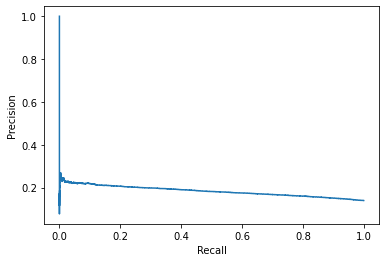

In [165]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precision, recall, _ = precision_recall_curve(Y_test, pr)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
print(auc(recall, precision))
plt.show()

In [166]:
l_x = pr_x
np.count_nonzero(l_x)

17965

In [167]:
print(classification_report(y_true=Y_test, y_pred=pr_x, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88    129261
           1       0.21      0.18      0.19     21026

    accuracy                           0.79    150287
   macro avg       0.54      0.53      0.54    150287
weighted avg       0.78      0.79      0.78    150287



No handles with labels found to put in legend.


0.5948733639788111


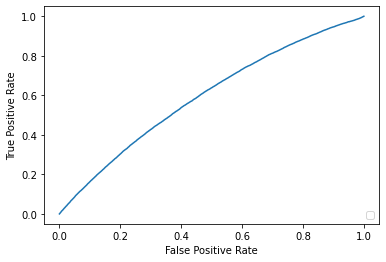

In [168]:
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(Y_test, pr)
print(auc(fpr, tpr))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [169]:
catboost.feature_importances_, catboost.feature_names_

(array([ 8.96078838,  7.52828127, 16.31941433,  2.98521491, 15.2094398 ,
         8.46959945,  5.79585591,  5.55797531,  0.83028472, 10.15592871,
         8.49048994,  9.69672726]),
 ['timestamp',
  'gender',
  'age',
  'country',
  'city',
  'exp_group',
  'os',
  'source',
  'topic',
  'tfidf_mean',
  'user_views',
  'post_views'])

In [131]:
import psycopg2
engine = create_engine("postgresql://..."
)
FOR_ML = df_test.copy()
FOR_ML
FOR_ML.to_sql('acylhan_lesson_22_7', con=engine, if_exists='replace') # записываем таблицу



In [132]:
sql = """SELECT *
            FROM public.acylhan_lesson_22_7 
           LIMIT 10"""
dfr = pd.read_sql(sql, "postgresql://...")
dfr

,index,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,topic,tfidf_mean,user_views,post_views
0,0,2021-11-11 12:44:21,121461,53,view,0,1,31,Russia,Krasnoyarsk,0,iOS,organic,business,7.027711,50,8269
1,1,2021-12-04 13:43:53,34370,53,view,0,0,20,Russia,Krasnogvardeyskoye,4,iOS,ads,business,7.027711,23,8269
2,2,2021-11-08 23:05:31,92729,53,view,0,1,15,Russia,Cherepovets,1,iOS,ads,business,7.027711,27,8269
3,3,2021-10-06 21:59:23,7361,53,view,1,0,35,Russia,Sarapul,1,iOS,ads,business,7.027711,61,8269
4,4,2021-11-27 21:09:49,121479,53,view,0,1,24,Russia,Kizlyar,2,Android,organic,business,7.027711,42,8269
5,5,2021-11-23 18:12:44,121484,53,view,0,1,23,Russia,Buy,0,Android,organic,business,7.027711,56,8269
6,6,2021-12-03 23:12:01,99490,53,view,0,0,23,Russia,Tomsk,1,Android,ads,business,7.027711,19,8269
7,7,2021-10-15 20:43:51,34391,53,view,0,1,26,Russia,Petrov Val,4,Android,ads,business,7.027711,32,8269
8,8,2021-11-08 16:19:13,34391,53,view,0,1,26,Russia,Petrov Val,4,Android,ads,business,7.027711,32,8269
9,9,2021-12-02 19:38:44,52407,53,view,0,1,42,Russia,Agidel,3,iOS,ads,business,7.027711,50,8269
